# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

1.0

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

### Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today()-datetime.timedelta(1),
                                        startdate=datetime.datetime(2024,5,5))
positions=positions.sort_index()
positions.index=pd.to_datetime(positions.index)

2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
LDUMAUSDT not retrieved


In [13]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [14]:
positions.to_excel('Positions.xlsx')

In [15]:
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

In [16]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=np.log(1+binance_data.pct_change())

LDUMAUSDT not retrieved
Total not retrieved


In [17]:
historical_ptf=pd.DataFrame()

In [18]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

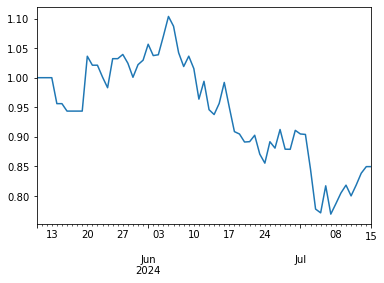

In [19]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [20]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [21]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use)
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [22]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT', 'ENSUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GNOUSDT', 'GRTUSDT',
       'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT',
       'LINKUSDT', 'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT',
       'NEXOUSDT', 'OMUSDT', 'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT',
       'RNDRUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT',
       'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT',
       'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'XLMUSDT', 'XRPUSDT',
       'XTZUSDT'],
      dtype='object')

## Optimal Portfolio

In [23]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[12]-0.30},
                                                           {'type': 'ineq', 'fun': lambda weights: weights[20]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
OMUSDT,0.389388
BTCUSDT,0.300000
ETHUSDT,0.150000
JASMYUSDT,0.079700
PEPEUSDT,0.057817
BNBUSDT,0.023095


In [24]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[0]-0.3},
                                                           {'type': 'ineq', 'fun': lambda weights: weights[2]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
OMUSDT,0.56749
BTCUSDT,0.30000
JASMYUSDT,0.13251


## Real Portfolio vs Optimal

In [25]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,667.824520,3.242622e-01,0.30000,0.024262
JASMYUSDT,340.802904,1.654769e-01,0.13251,0.032967
OMUSDT,234.528966,1.138755e-01,0.56749,-0.453614
ETHUSDT,231.342812,1.123285e-01,0.00000,0.000000
SOLUSDT,222.147937,1.078639e-01,0.00000,0.000000
BBUSDT,158.661776,7.703823e-02,0.00000,0.000000
MKRUSDT,125.804274,6.108427e-02,0.00000,0.000000
BNBUSDT,56.821262,2.758956e-02,0.00000,0.000000
TRXUSDT,21.585601,1.048089e-02,0.00000,0.000000
PEPEUSDT,0.000002,1.098897e-09,0.00000,0.000000


In [26]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,667.824520,3.242622e-01,0.300000,0.024262
JASMYUSDT,340.802904,1.654769e-01,0.079700,0.085777
OMUSDT,234.528966,1.138755e-01,0.389388,-0.275512
ETHUSDT,231.342812,1.123285e-01,0.150000,-0.037671
SOLUSDT,222.147937,1.078639e-01,0.000000,0.000000
BBUSDT,158.661776,7.703823e-02,0.000000,0.000000
MKRUSDT,125.804274,6.108427e-02,0.000000,0.000000
BNBUSDT,56.821262,2.758956e-02,0.023095,0.004495
TRXUSDT,21.585601,1.048089e-02,0.000000,0.000000
PEPEUSDT,0.000002,1.098897e-09,0.057817,-0.057817


## Risk Reward Analysis

<AxesSubplot:>

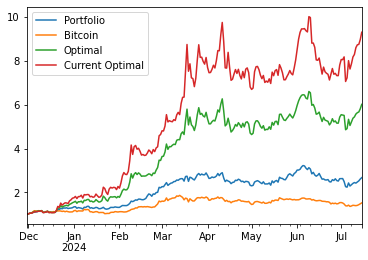

In [27]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
(1+portfolio_perf).cumprod().plot()

In [28]:
portfolio_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

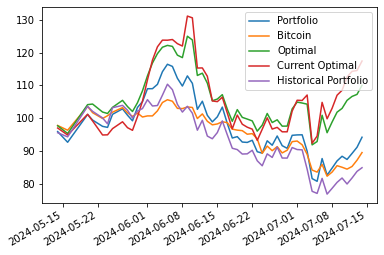

In [29]:
((1+portfolio_perf.loc[positions.index]).cumprod()*100).plot()

In [30]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.691633
dtype: float64

In [31]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio               0.510206
Bitcoin                 0.438365
Optimal                 0.693092
Current Optimal         0.874327
Historical Portfolio    0.487735
dtype: float64

In [32]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.003259,0.005362,0.006971,0.000285,0.006686
BTCUSDT,0.018524,0.048359,0.125694,0.036002,0.089691
ETHUSDT,0.008077,0.023120,0.065188,0.011706,0.053481
JASMYUSDT,0.019753,0.026107,0.055161,0.017482,0.037679
OMUSDT,0.930646,0.873275,0.693405,0.596166,0.097239
PEPEUSDT,0.019741,0.023777,0.053581,0.013066,0.040516


In [33]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,-0.105436,0.293525,0.172936,0.041805,0.131132
JASMYUSDT,0.645800,0.199610,0.267990,0.108685,0.159304
OMUSDT,0.721279,0.148041,0.116171,0.032745,0.083426
ETHUSDT,0.159594,0.113086,0.078081,0.009714,0.068367
SOLUSDT,-0.052330,0.099898,0.108746,0.017638,0.091108
BBUSDT,-0.331918,0.054366,0.182553,0.061758,0.120795
MKRUSDT,-0.014948,0.055336,0.053457,0.005346,0.048111
BNBUSDT,-0.035874,0.025901,0.018410,0.000592,0.017819
TRXUSDT,0.013832,0.010238,0.001656,0.000017,0.001639


## Value At Risk

### Historical

In [34]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05716093308633462, -0.08376954085426465)

In [35]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05202751752836412, -0.06850759360108656)

### Parametric

In [36]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07181548326275608, -0.09204759366141467)

In [37]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05913319456096899, -0.07579240600435054)

### Multivariate

In [38]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.062375872092036336, -0.0800863278930569)

In [39]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06010486567881114, -0.07471809203602418)

### Copulas

In [40]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06338416695391857, -0.08129609362356842)

In [41]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.056963961972752955, -0.07273231907627524)

In [42]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06325711644940205, -0.08172341466137965)

In [43]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05925025771882403, -0.07549128225248901)

### Monte Carlo

In [44]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07533410727754328, -0.09307904439841062)

In [45]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06068493707371782, -0.07536832664369242)

### VaR Violation

In [46]:
var_data=rolling_var(returns_to_use,opt_weights,window=25,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-09,-0.055455,-0.097437,-0.076828,-0.004807
2024-01-10,-0.055455,-0.097451,-0.080048,0.026785
2024-01-11,-0.055455,-0.096588,-0.077271,0.002525
2024-01-12,-0.056291,-0.102381,-0.085070,-0.055177
2024-01-13,-0.056291,-0.102134,-0.084470,0.012225
...,...,...,...,...
2024-07-11,-0.102858,-0.093955,-0.094810,0.023760
2024-07-12,-0.102858,-0.091901,-0.086037,0.011321
2024-07-13,-0.102858,-0.090025,-0.086809,0.005894
2024-07-14,-0.102858,-0.089343,-0.086896,0.025893


In [47]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.039528,-0.095447,-0.086056,-0.018866
2024-05-29,-0.033381,-0.091583,-0.079977,-0.016852
2024-05-30,-0.033381,-0.081730,-0.072868,0.041124
2024-05-31,-0.028811,-0.077009,-0.063612,0.016947
2024-06-01,-0.028811,-0.077718,-0.064239,0.037418
2024-06-02,-0.028811,-0.078086,-0.066528,0.000143
2024-06-03,-0.019179,-0.073189,-0.057658,0.012092
2024-06-04,-0.019179,-0.056325,-0.045168,0.034909
2024-06-05,-0.019179,-0.053524,-0.041278,0.019814
2024-06-06,-0.019179,-0.053759,-0.039298,-0.005659


<AxesSubplot:>

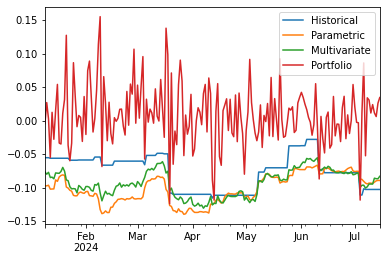

In [48]:
var_data.plot()

<AxesSubplot:>

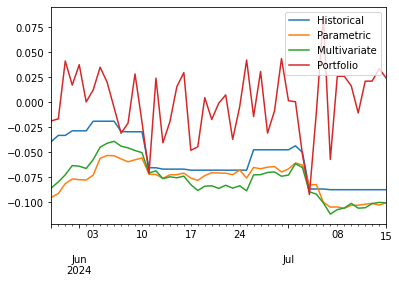

In [49]:
current_var_data.plot()

In [50]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.031746,0.010582,0.015873
Kupiec Stat,1.514807,8.993461,6.244564
P-value,0.218407,0.002709,0.012458


In [51]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.081633,0.020408,0.040816
Kupiec Stat,0.873844,1.152529,0.092573
P-value,0.349893,0.28302,0.760931


## Principal Component Analysis

In [52]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.75978611, 0.07558132, 0.06404262, 0.05580086, 0.04478909])

In [53]:
eigval,eigvec,portfolio_components=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.61802006, 0.15553332, 0.09914248, 0.08205763, 0.04524651])